In [1]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## Install Data

In [2]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet -O data/yellow_tripdata_2022-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet -O data/yellow_tripdata_2022-02.parquet

--2023-05-19 23:39:13--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 2600:9000:2156:cc00:b:20a5:b140:21, 2600:9000:2156:d800:b:20a5:b140:21, 2600:9000:2156:5000:b:20a5:b140:21, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|2600:9000:2156:cc00:b:20a5:b140:21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38139949 (36M) [application/x-www-form-urlencoded]
Saving to: ‘data/yellow_tripdata_2022-01.parquet’

data/yellow_tripdat 100%[===================>]  36,37M  10,9MB/s    in 3,4s    

2023-05-19 23:39:17 (10,8 MB/s) - ‘data/yellow_tripdata_2022-01.parquet’ saved [38139949/38139949]

--2023-05-19 23:39:17--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 2600:9000:2156:d800:b:20a5:b140:21, 2600:9000:2156:4c00:b:20

## Q1

In [3]:
import pandas as pd


df_jan = pd.read_parquet('data/yellow_tripdata_2022-01.parquet')

print(f"total columns are {len(df_jan.columns)}")

total columns are 19


## Q2

In [4]:
import numpy as np
df_jan['duration_min'] =  (df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime) / np.timedelta64(1, 'm')
print(f'trip duration std in january is {df_jan.duration_min.std()}m')

trip duration std in january is 46.44530513776802m


## Q3

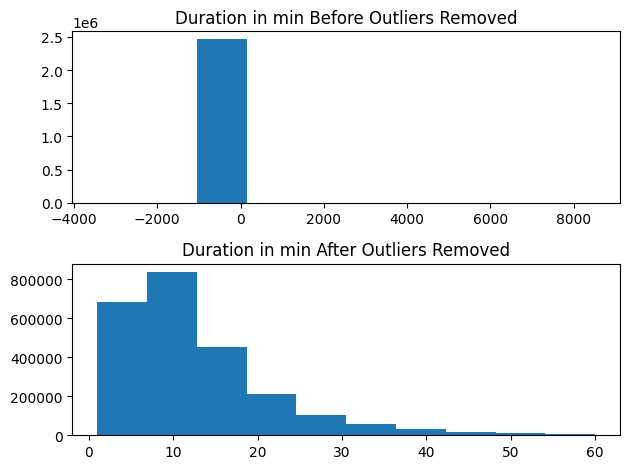

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df_jan_filtered = df_jan[(1 <= df_jan.duration_min) & (df_jan.duration_min <= 60)]

plt.subplot(2, 1, 1)
plt.hist(df_jan.duration_min, bins=10)
plt.title('Duration in min Before Outliers Removed')
plt.subplot(2, 1, 2)
plt.hist(df_jan_filtered.duration_min, bins=10)
plt.title('Duration in min After Outliers Removed')
plt.tight_layout()

In [6]:
print(f'after removing the outlier {100 * len(df_jan_filtered)/len(df_jan)}% of the data remained')

after removing the outlier 98.27547930522405% of the data remained


## Q4

In [7]:
from sklearn.feature_extraction import DictVectorizer

df_jan_filtered = df_jan_filtered.astype({"PULocationID": str, "DOLocationID": str})
dict_jan = df_jan_filtered[['PULocationID', 'DOLocationID']].to_dict('records')


In [8]:
dv = DictVectorizer(sparse=False).fit(dict_jan)
feat_jan = dv.transform(dict_jan)

print(f'total number of columns are {feat_jan.shape[1]}')

total number of columns are 515


## Q6

In [9]:
from sklearn.linear_model import LinearRegression

duration_jan = df_jan_filtered.duration_min.values
reg = LinearRegression(n_jobs=-1).fit(feat_jan, duration_jan)

In [10]:
from sklearn.metrics import mean_squared_error

duration_jan_pred = reg.predict(feat_jan)

mean_squared_error(duration_jan, duration_jan_pred, squared=False)

6.986191042436684

## Q7

In [11]:
df_feb = pd.read_parquet('data/yellow_tripdata_2022-02.parquet')

df_feb['duration_min'] =  (df_feb.tpep_dropoff_datetime - df_feb.tpep_pickup_datetime) / np.timedelta64(1, 'm')
df_feb_filtered = df_feb[(1 <= df_feb.duration_min) & (df_feb.duration_min <= 60)]

df_feb_filtered = df_feb_filtered.astype({"PULocationID": str, "DOLocationID": str})
dict_feb = df_feb_filtered[['PULocationID', 'DOLocationID']].to_dict('records')

feat_feb = dv.transform(dict_feb)

duration_feb_pred = reg.predict(feat_feb)
duration_feb_pred[np.where(np.sum(feat_feb, axis=1) < 2)] = 0
duration_feb = df_feb_filtered.duration_min.values

mean_squared_error(duration_feb, duration_feb_pred, squared=False)

7.7864206955560125